# Get VAD working on GRN data
Try using webrtcvad to identify segments of audio

In [1]:
import librosa
import webrtcvad
import os
import sys
module_path = os.path.abspath(os.path.join('work/vox-grn/Projects/vad_utils'))
if module_path not in sys.path:
    sys.path.append(module_path)
from vad_utils import SAMPLING_RATE, FRAME_SIZE_MS, SAMPLES_PER_FRAME
import vad_utils as vu

## Voice Activity Detector
This is the VAD recommended by SIL.

It takes mono 16 bit PCM input for frames. The size of the frames gives the resolution of the output. Note that GRN data is 32 bit stereo.
The authors recommend a 2 state output filter which measures for 90% threshold to trigger on and then off 90% to change off. This is effectively a moving average filter with two thresholds. They make the length of the filter variable but set it at 300ms, which seems reasonable.

In [19]:
vad = webrtcvad.Vad(2)

In [3]:
# Open a test file and break it into frames
# Yuruti - an unknown language
# wav = librosa.load('/media/programs/Programs/37/37779/A37779/PM-0811/A37779-0811-02.wav', sr=SAMPLING_RATE)
# English - South African
wav, _ = librosa.load('/media/programs/Programs/65/65132/A65132/PM-1601/A65132-01.wav', sr=SAMPLING_RATE, mono=True)
# Italian
# wav = librosa.load('/media/programs/Programs/65/65428/A65428/PM-1612/A65428-02.wav', sr=SAMPLING_RATE)
# khmer
# wav = librosa.load('/media/programs/Programs/03/03400/A03400/MM/A03400-01.wav', sr=SAMPLING_RATE)



In [4]:
#frames = frame_generator(30, stereo_to_mono(wav), SAMPLING_RATE)
frames = vu.frame_generator(FRAME_SIZE_MS, wav, SAMPLING_RATE)
frame_list = [f for f in frames]
len(frame_list)

10005

In [20]:
speech = [vad.is_speech(frame.bytes, SAMPLING_RATE) for frame in frame_list]

In [6]:
len(wav)/FRAME_SIZE_MS/SAMPLING_RATE*1000

10005.585416666667

The input is expected to be 16 bit fixed point. What is the nature of our input?

In [7]:
print(f'Max of data {max(wav)}, min {min(wav)}')

Max of data 0.8208070993423462, min -0.646919310092926


In [21]:
sum(speech)

7059

Now lets look at the output of real data

In [22]:
vadfilt = vu.VADFilter()
vadout = [vadfilt.filt(s) for s in speech]
sum(vadout)

7222

Now we want to find the timing of the segments. Form a list of segments.

In [23]:
segs = vu.form_segments(vadout)
for seg in segs:
    print(f'{seg}')

Start: 1.47 Stop: 2.37
Start: 3.15 Stop: 4.83
Start: 5.61 Stop: 7.02
Start: 7.8 Stop: 10.47
Start: 11.37 Stop: 18.63
Start: 19.41 Stop: 22.59
Start: 23.22 Stop: 23.97
Start: 24.27 Stop: 26.46
Start: 26.76 Stop: 27.72
Start: 27.99 Stop: 30.15
Start: 31.26 Stop: 32.49
Start: 34.62 Stop: 37.35
Start: 38.25 Stop: 40.71
Start: 42.84 Stop: 43.98
Start: 44.49 Stop: 47.19
Start: 48.21 Stop: 49.41
Start: 50.07 Stop: 51.93
Start: 52.23 Stop: 53.61
Start: 53.88 Stop: 55.44
Start: 55.89 Stop: 56.58
Start: 57.0 Stop: 58.77
Start: 59.49 Stop: 60.51
Start: 60.87 Stop: 62.16
Start: 62.43 Stop: 64.14
Start: 65.28 Stop: 67.5
Start: 69.63 Stop: 72.18
Start: 72.57 Stop: 76.86
Start: 78.87 Stop: 80.55
Start: 82.26 Stop: 83.73
Start: 84.21 Stop: 88.74
Start: 90.03 Stop: 90.6
Start: 91.05 Stop: 93.0
Start: 93.51 Stop: 95.19
Start: 96.12 Stop: 98.25
Start: 98.73 Stop: 102.9
Start: 104.58 Stop: 110.34
Start: 111.51 Stop: 115.83
Start: 116.34 Stop: 117.06
Start: 117.48 Stop: 119.76
Start: 122.85 Stop: 126.66
St

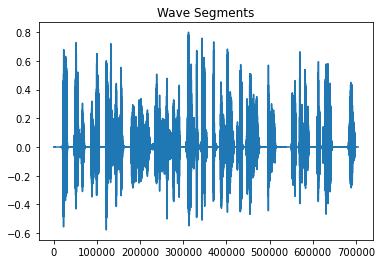

In [11]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.title('Wave Segments')
stop = segs[10].stop * SAMPLES_PER_FRAME
plt.plot(wav[:int(stop)])

Of course audio is made up of utterances and silences. How long can a silence be before it is not useful? What percentage of an utterance can be silence? Get some stats.

In [12]:
utterances = [(s.stop - s.start) * SAMPLES_PER_FRAME / SAMPLING_RATE for s in segs]
silences = [(s1.start - s0.stop) * SAMPLES_PER_FRAME / SAMPLING_RATE for s0, s1 in zip(segs, segs[1:])]

<AxesSubplot:ylabel='Frequency'>

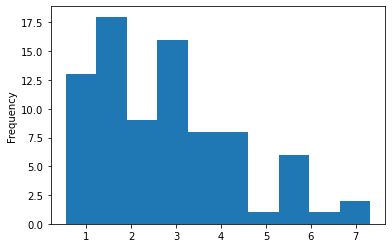

In [13]:
import pandas as pd

utterances = pd.Series(utterances)
silences = pd.Series(silences)

utterances.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

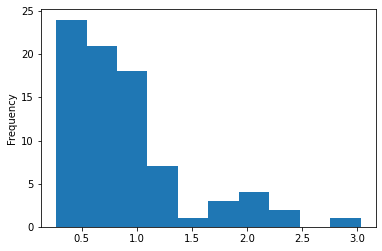

In [14]:
silences.plot(kind='hist')

So we want to find segments of a given length and can contain silences of up to 1 second.

In [15]:
segs_6sec = vu.divide_into_segments(segs, 6.0)

In [16]:
for seg in segs_6sec:
    print(f'{seg}')

Start: 1.47 Stop: 7.47
Start: 11.37 Stop: 17.37
Start: 19.38 Stop: 25.38
Start: 31.26 Stop: 37.26
Start: 38.22 Stop: 44.22
Start: 48.21 Stop: 54.21
Start: 55.89 Stop: 61.89
Start: 65.28 Stop: 71.28
Start: 72.57 Stop: 78.57
Start: 82.26 Stop: 88.26
Start: 90.0 Stop: 96.0
Start: 98.73 Stop: 104.73
Start: 111.51 Stop: 117.51
Start: 122.85 Stop: 128.85
Start: 133.89 Stop: 139.89
Start: 141.15 Stop: 147.15
Start: 151.77 Stop: 157.77
Start: 161.16 Stop: 167.16
Start: 169.05 Stop: 175.05
Start: 178.38 Stop: 184.38
Start: 185.91 Stop: 191.91
Start: 193.41 Stop: 199.41
Start: 200.79 Stop: 206.79
Start: 209.01 Stop: 215.01
Start: 219.21 Stop: 225.21
Start: 230.52 Stop: 236.52
Start: 237.93 Stop: 243.93
Start: 245.31 Stop: 251.31
Start: 257.7 Stop: 263.7
Start: 268.95 Stop: 274.95
Start: 277.26 Stop: 283.26
Start: 286.95 Stop: 292.95


In [17]:
segs_10sec = vu.divide_into_segments(segs, 10.0)
for s in segs_10sec:
    print(f'{s}')

Start: 1.47 Stop: 11.46
Start: 19.38 Stop: 29.37
Start: 31.26 Stop: 41.25
Start: 44.49 Stop: 54.48
Start: 55.89 Stop: 65.88
Start: 69.6 Stop: 79.59
Start: 82.26 Stop: 92.25
Start: 93.51 Stop: 103.5
Start: 111.51 Stop: 121.5
Start: 127.68 Stop: 137.67
Start: 138.99 Stop: 148.98
Start: 151.77 Stop: 161.76
Start: 163.68 Stop: 173.67
Start: 176.37 Stop: 186.36
Start: 189.36 Stop: 199.35
Start: 200.79 Stop: 210.78
Start: 212.64 Stop: 222.63
Start: 230.52 Stop: 240.51
Start: 241.02 Stop: 251.01
Start: 257.7 Stop: 267.69
Start: 268.95 Stop: 278.94
Start: 283.71 Stop: 293.7


In [18]:
segs_20sec = vu.divide_into_segments(segs, 20.0)
for seg in segs_20sec:
    print(f'{seg}')

Start: 1.47 Stop: 21.45
Start: 23.22 Stop: 43.2
Start: 44.49 Stop: 64.47
Start: 69.6 Stop: 89.58
Start: 91.05 Stop: 111.03
Start: 116.34 Stop: 136.32
Start: 138.99 Stop: 158.97
Start: 163.68 Stop: 183.66
Start: 185.91 Stop: 205.89
Start: 209.01 Stop: 228.99
Start: 230.52 Stop: 250.5
Start: 257.7 Stop: 277.68
